
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [49]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

This project is about online news coverage of inequality in the United States. I am going to see if the coverage given to income inequality from 2015 to 2020 reflects the empirical rise in inequality during the same period. I am also interested in how online media frames income inequality, like the causes and solutions.

## ***Why?***
<200 words

Understanding public perception of inequality and social mobility is essential. With massive data and research showing that the gap between the rich and poor in the US keeps enlarging in recent years, I am interested in how online media frames this question. Extracting topics, reasons, and solutions of inequality online may offer us a new perspective on reducing inequality. 
     

## ***How?***
<400 words

Dynamic topic modeling: to see if the online news coverage trend given to income inequality from 2015 to 2020 
    
Word embedding: to describe the general world view of the online news. After that, I will build several dimensions and project the news onto these dimensions to see if there's any systematic difference (or similarity) in terms of the causes and solutions.

Network analysis:  Considering news itself can be biased, I am going to use network analysis to see the differences of news topics among sources. 
    
## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words
    
I am interested in the news framing of inequality in the US, so I choose the NOW corpus to analyze the online news. The limitation of this proposal is that the news itself could be biased, so its description of inequality is not always objective. In the future study, I plan to employ a larger corpus. Also, I am particularly interested in China's inequality, so I may collect news articles from Chinese news websites instead.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [52]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [53]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [54]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [55]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [56]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [57]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [58]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [59]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [60]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [61]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [62]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [63]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [64]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [65]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [66]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [67]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [68]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,1
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data\20news_home\20news-b...,1
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0


We can also look at the distinguishing features in each cluster:

In [69]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 thanks
 mac
 just
 does
 like
 drive
 apple
 don
 problem


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer


Cluster 2:
 window
 server
 motif
 use
 widget
 program
 using
 application
 like
 code


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [70]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [71]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [72]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

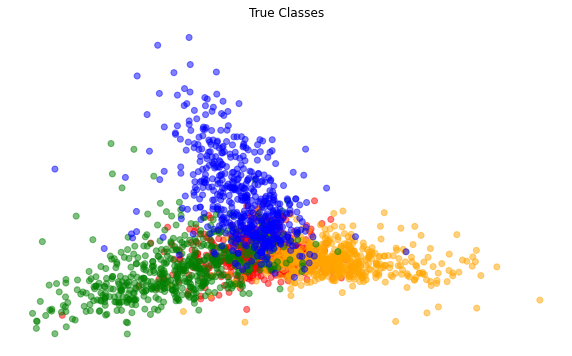

In [73]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

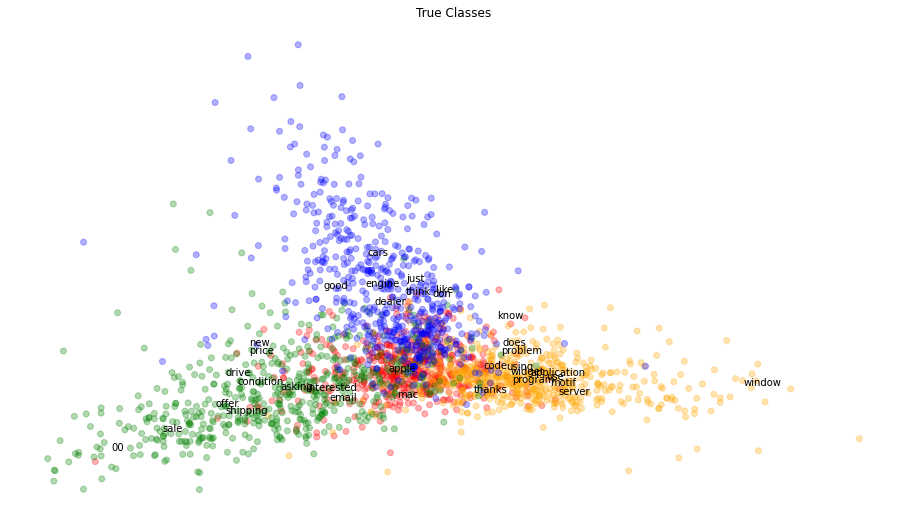

In [74]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [75]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

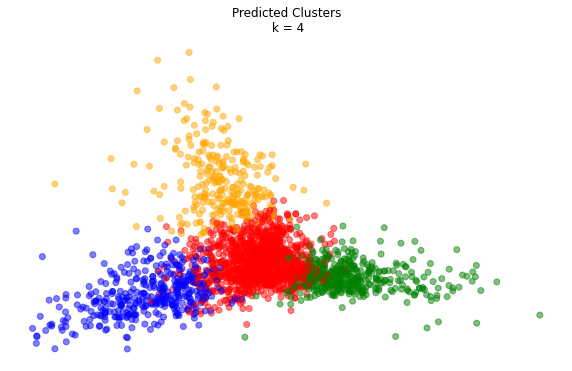

In [76]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [77]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [78]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


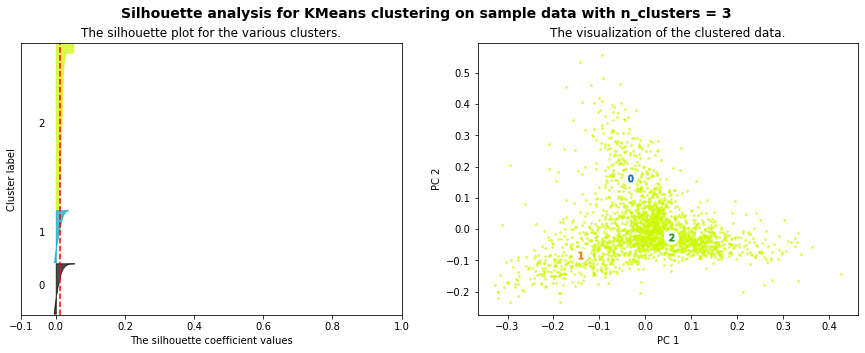

For n_clusters = 3, The average silhouette_score is : 0.013


In [79]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


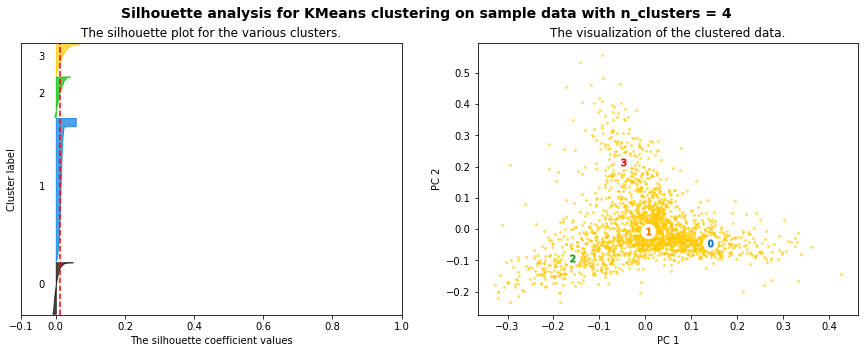

For n_clusters = 4, The average silhouette_score is : 0.012


In [80]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


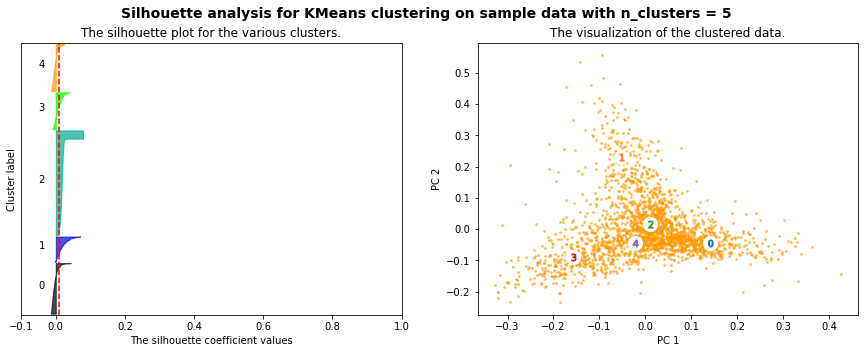

For n_clusters = 5, The average silhouette_score is : 0.010


In [81]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


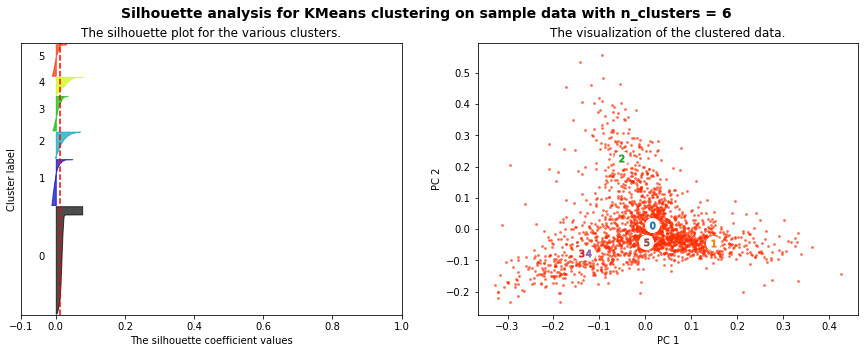

For n_clusters = 6, The average silhouette_score is : 0.012


In [82]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [83]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [84]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [85]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [86]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [87]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [88]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [89]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

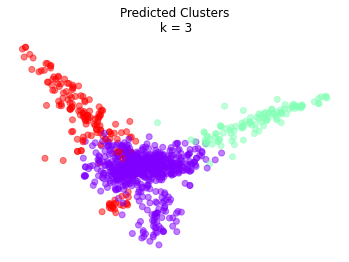

In [90]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [91]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,0
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,0
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

Dataset 1: News in Now corpus containing "inequality" and "mobility"

In [107]:
import zipfile
import os

In [108]:
corpora_address = "/Users/xiche/Downloads/Compressed/NOW-2019"
now_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text-19-01.zip
text-19-02.zip
text-19-03.zip
text-19-04.zip
text-19-05.zip
text-19-06.zip
text-19-07.zip
text-19-08.zip
text-19-09.zip


In [109]:
def get_source(file_name):
    zfile = zipfile.ZipFile(corpora_address + file_name)
    source = []
    for file in zfile.namelist():
        with zfile.open(file) as f:
            for line in f:
                source.append(line)
    return source

In [110]:
def get_dict(source):
    now_txt_dict = {}
    now_dict = {}
    for news in source:
        news_str = news.decode("utf-8")
        if ("inequality" in news_str) | ("mobility" in news_str):
            try:
                textID_title = news_str.split("<p>")[0].strip("@@")
                l_texts = news_str.split("<p>")[1:]
                if "<h>" in textID_title:
                    textID = textID_title.split("<h>")[0]
                    title = textID_title.split("<h>")[-1]
                else:
                    textID = textID_title
                now_txt_dict[textID.strip()] = " ".join(l_texts)
            except UnicodeDecodeError:
                continue
            if textID.strip() not in now_dict:
                now_dict[textID.strip()] = []
            if textID.strip() in now_dict:
                try:
                    now_dict[textID.strip()].append(now_texts[textID.strip()])
                except KeyError:
                    continue
    return now_txt_dict, now_dict

In [111]:
l_df2 = []
for zip_name in os.listdir(corpora_address):  
    if zip_name != ".DS_Store":
        print(zip_name)
        if "text-19" in zip_name:
            source19 = get_source("/" + zip_name)
            nowtxtDict2 = get_dict(source19)[0]
            nowDF2 = pandas.DataFrame(nowtxtDict2.items(), \
                                  columns = ['textID','texts'])
            l_df2.append(nowDF2)

sources-19-01.zip
sources-19-02.zip
sources-19-03.zip
sources-19-04.zip
sources-19-05.zip
sources-19-06.zip
sources-19-07.zip
sources-19-08.zip
sources-19-09.zip
text-19-01.zip
text-19-02.zip
text-19-03.zip
text-19-04.zip
text-19-05.zip
text-19-06.zip
text-19-07.zip
text-19-08.zip
text-19-09.zip


In [112]:
nowDF2 = l_df2[0]
for df in l_df2:
    nowDF2 = nowDF2.append(df)

nowDF2["year"] = ["2019"] * len(nowDF2)

In [113]:
print("The number of news that mentioned inequality in 2019 is", len(nowDF2))

The number of news that mentioned inequality in 2019 is 28338


In [114]:
nowDF_2019 = nowDF2.drop_duplicates(["texts"])
nowDF_2019

,textID,texts,year
0,50321297,"With summer well and truly upon us , there is...",2019
1,50323336,The Roman emperor Augustus is held up by some...,2019
2,50326050,1 in 6 women experience physical and/or sexua...,2019
3,50326526,Toyota HiLux is the best selling vehicle in t...,2019
4,50326747,"Hop Lin Jong , seen here in 1948 , was born i...",2019
...,...,...,...
3257,80855162,"3 Min Read FRANKFURT , Sept 2 ( Reuters ) -...",2019
3258,81003375,Following a fruitful rainy season and several...,2019
3259,81035766,""" Metrorail confirms that three carriages of ...",2019
3260,81165017,TUNIS ( Reuters ) - Tunisia 's Zine El-Abidin...,2019


In [115]:
#First it needs to be initialized
nowCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
nowVects = nowCountVectorizer.fit_transform(nowDF_2019['texts'])
print(nowVects.shape)

#initialize
nowTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(nowVects)
#train
nowTF = nowTFTransformer.transform(nowVects)
print(nowTF.shape)

(24849, 226126)
(24849, 226126)


In [116]:
list(zip(nowCountVectorizer.vocabulary_.keys(), nowTF.data))[:20]

[('with', 0.1516766421317301),
 ('summer', 0.1011177614211534),
 ('well', 0.020603792192794023),
 ('and', 0.042120313243814794),
 ('truly', 0.016461895199335948),
 ('upon', 0.02143035384070725),
 ('us', 0.01522896443056878),
 ('there', 0.01237652278462839),
 ('is', 0.016208115072892826),
 ('no', 0.01551486984102233),
 ('better', 0.02386558778824832),
 ('time', 0.02319479487360018),
 ('than', 0.025716997476434918),
 ('now', 0.032555290085753),
 ('to', 0.06825664358057933),
 ('check', 0.048334656682713986),
 ('out', 0.03672287790107723),
 ('all', 0.024149688969091723),
 ('of', 0.0565088746781404),
 ('the', 0.024954924221696116)]

In [117]:
#initialize
nowTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, 
                                                                  min_df=3, stop_words='english', norm='l2')
#train
nowTFVects = nowTFVectorizer.fit_transform(nowDF_2019['texts'])
print(nowTFVects.shape)

(24849, 1000)


In [118]:
list(zip(nowTFVectorizer.vocabulary_.keys(), nowTFVects.data))[:20]

[('better', 0.04154629060046703),
 ('national', 0.044681625957142326),
 ('park', 0.04424925110400094),
 ('offer', 0.05015290349639106),
 ('community', 0.04604276197513761),
 ('list', 0.041977349728646376),
 ('things', 0.06151670000343852),
 ('related', 0.08693652647464628),
 ('safety', 0.11069806203902391),
 ('mr', 0.10605442034529984),
 ('great', 0.12593257892925971),
 ('place', 0.09435906562296262),
 ('important', 0.0927274082426462),
 ('care', 0.13565838333134062),
 ('responsible', 0.15453386337454014),
 ('make', 0.13080437358203864),
 ('good', 0.1431849851612187),
 ('responsibility', 0.053673401552494025),
 ('cultural', 0.06766076131973876),
 ('natural', 0.05070500956491176)]

In [119]:
# K means
def Kmeans(numClusters):
    km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
    km.fit(nowTFVects)
    nowDF_2019['kmeans_predictions'] = km.labels_

    terms = nowTFVectorizer.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(numClusters):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')

In [120]:
# 2 clusters
Kmeans(2)

Top terms per cluster:
Cluster 0:
 women
 government
 world
 years
 city
 just
 work
 public
 social
 says


Cluster 1:
 nigeria
 nan
 news
 gathering
 substantial
 36
 knows
 states
 state
 president




<ipython-input-119-42c43bb65dc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nowDF_2019['kmeans_predictions'] = km.labels_


In [121]:
# 3 clusters
Kmeans(3)

Top terms per cluster:
Cluster 0:
 women
 gender
 men
 female
 girls
 violence
 equality
 woman
 work
 world


Cluster 1:
 nigeria
 nan
 news
 gathering
 substantial
 36
 knows
 states
 state
 president


Cluster 2:
 government
 world
 city
 years
 just
 work
 public
 electric
 economic
 country




<ipython-input-119-42c43bb65dc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nowDF_2019['kmeans_predictions'] = km.labels_


In [122]:
# 4 clusters
Kmeans(4)

Top terms per cluster:
Cluster 0:
 government
 just
 world
 social
 economic
 years
 work
 country
 inequality
 state


Cluster 1:
 electric
 vehicles
 company
 car
 technology
 vehicle
 city
 transport
 cars
 business


Cluster 2:
 nigeria
 nan
 news
 gathering
 substantial
 36
 knows
 states
 state
 president


Cluster 3:
 women
 gender
 men
 female
 girls
 equality
 violence
 woman
 work
 world




<ipython-input-119-42c43bb65dc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nowDF_2019['kmeans_predictions'] = km.labels_


We can find some important topics of inequality from the clusters. Like gender inequality, city construction, etc. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


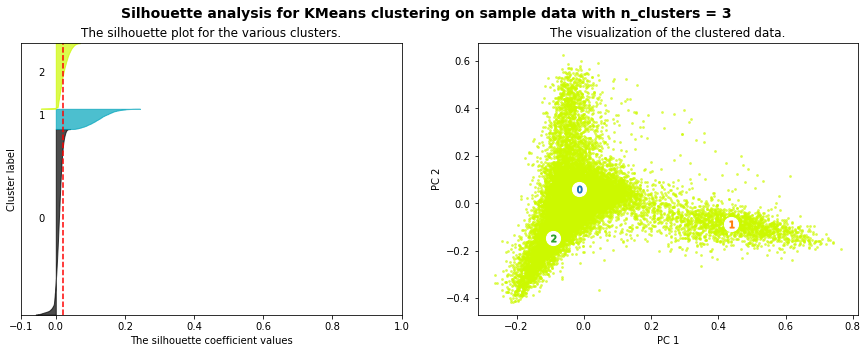

For n_clusters = 3, The average silhouette_score is : 0.020


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


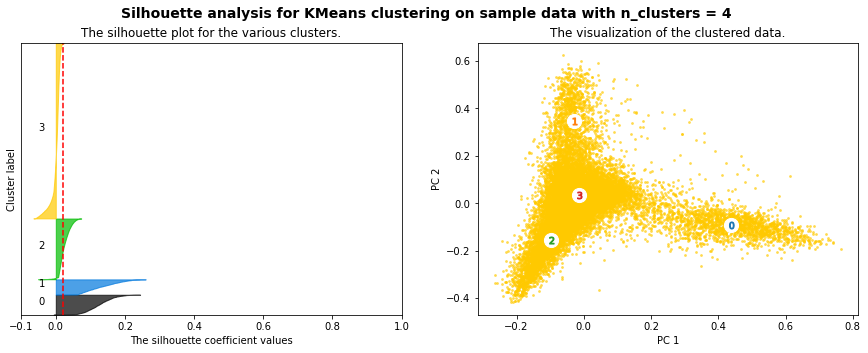

For n_clusters = 4, The average silhouette_score is : 0.022


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


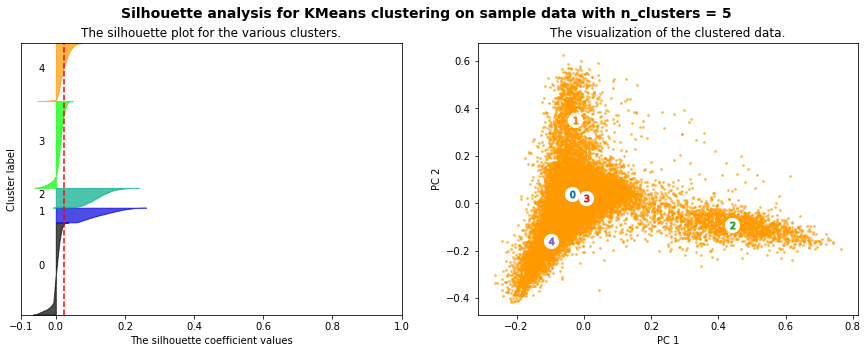

For n_clusters = 5, The average silhouette_score is : 0.025


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


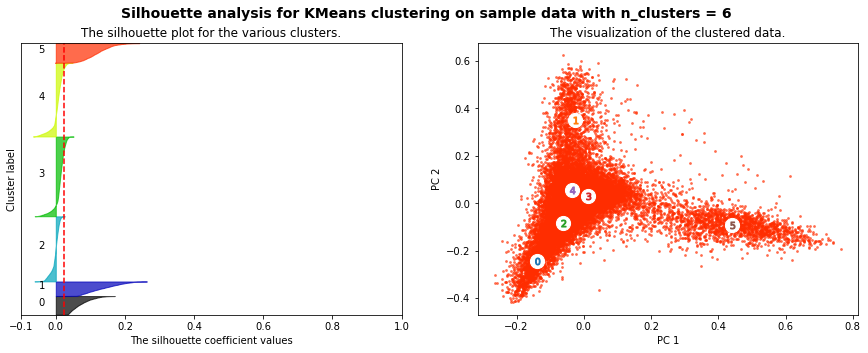

For n_clusters = 6, The average silhouette_score is : 0.025


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


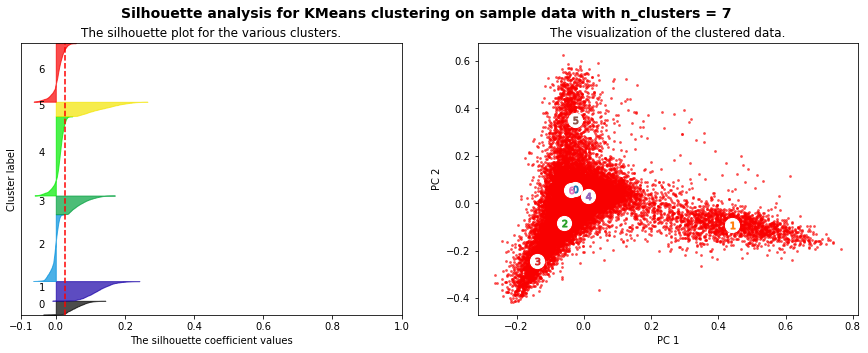

For n_clusters = 7, The average silhouette_score is : 0.026


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


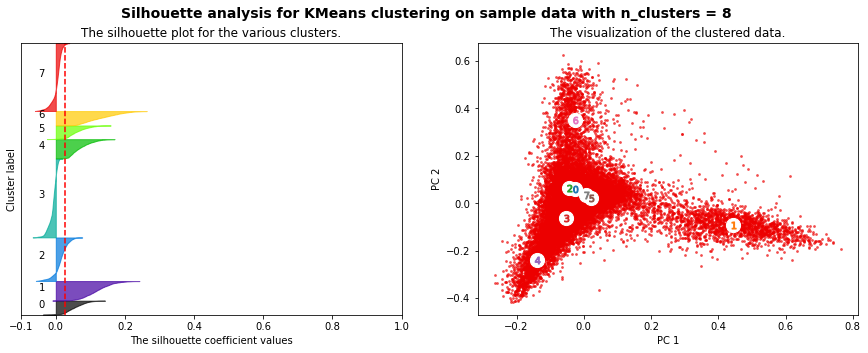

For n_clusters = 8, The average silhouette_score is : 0.026


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


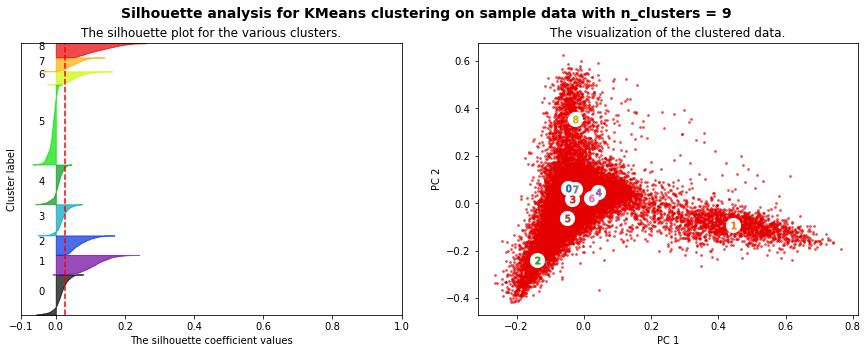

For n_clusters = 9, The average silhouette_score is : 0.027


In [122]:
# Silhouette
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(nowTFVects.toarray())
reduced_data = pca.transform(nowTFVects.toarray())
X = nowTFVects.toarray()
for n in range(3, 10): 
    plotSilhouette(n, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


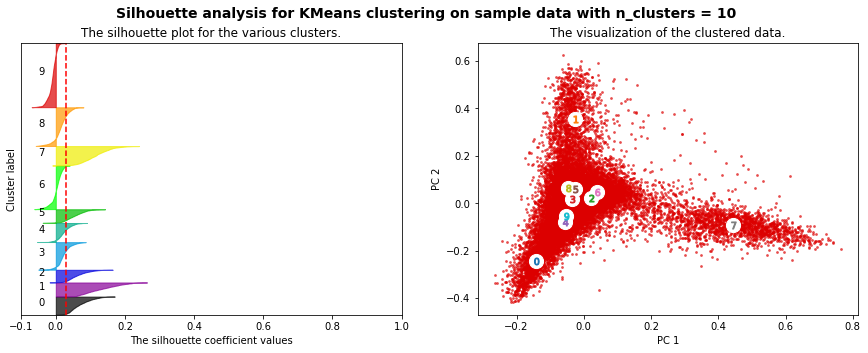

For n_clusters = 10, The average silhouette_score is : 0.029


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


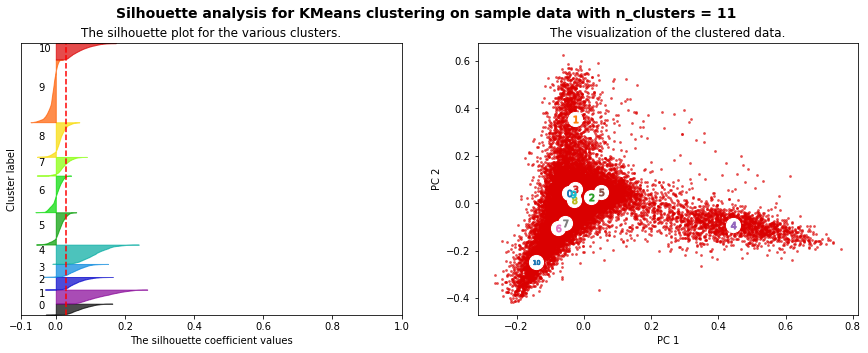

For n_clusters = 11, The average silhouette_score is : 0.030


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


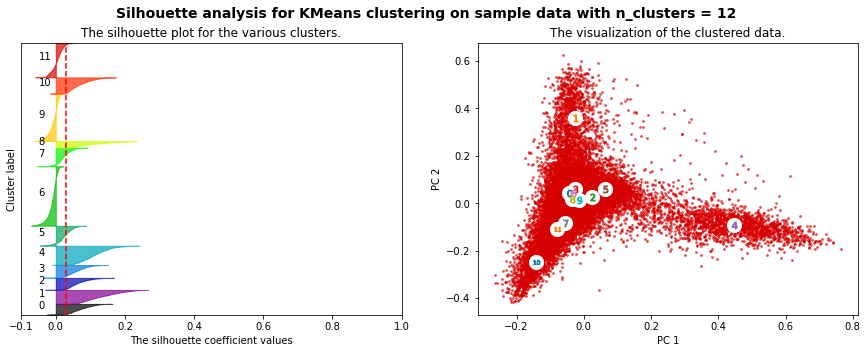

For n_clusters = 12, The average silhouette_score is : 0.030


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


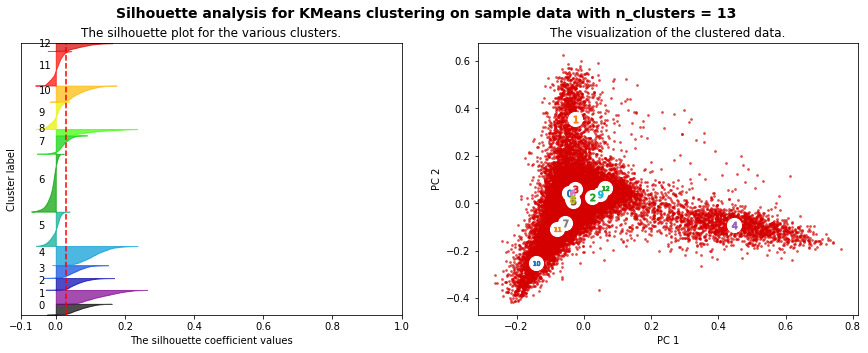

For n_clusters = 13, The average silhouette_score is : 0.030


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


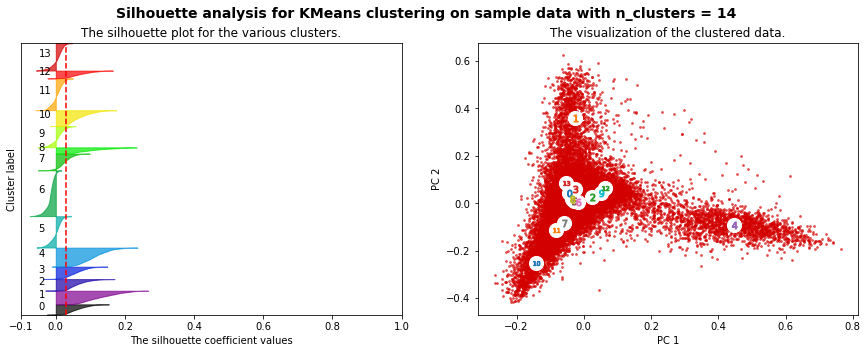

For n_clusters = 14, The average silhouette_score is : 0.030


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


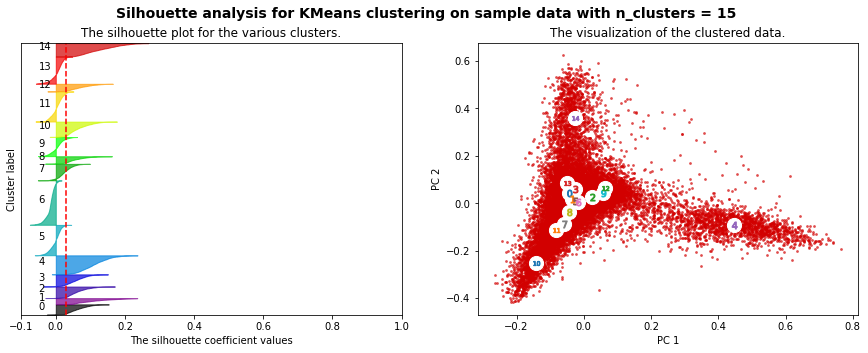

For n_clusters = 15, The average silhouette_score is : 0.031


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


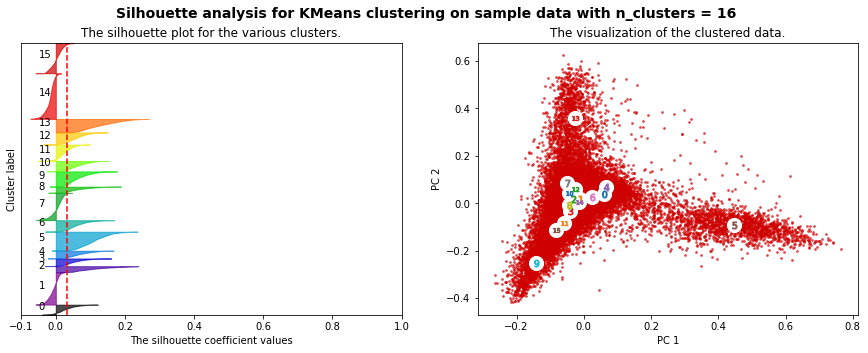

For n_clusters = 16, The average silhouette_score is : 0.031


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


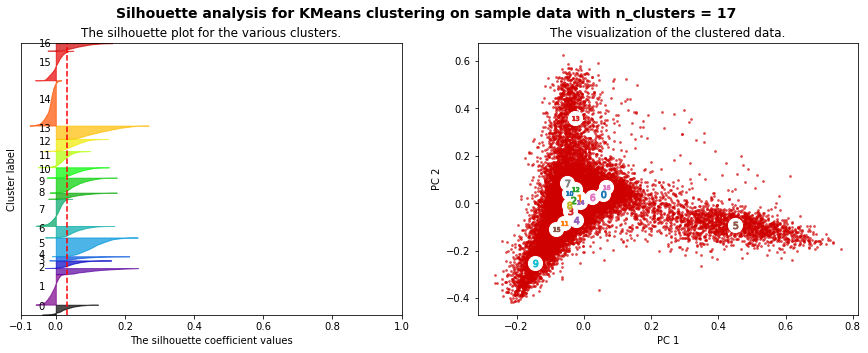

For n_clusters = 17, The average silhouette_score is : 0.032


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


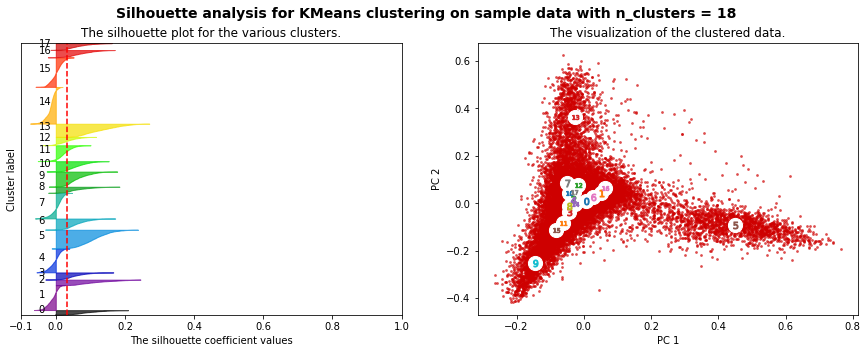

For n_clusters = 18, The average silhouette_score is : 0.032


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


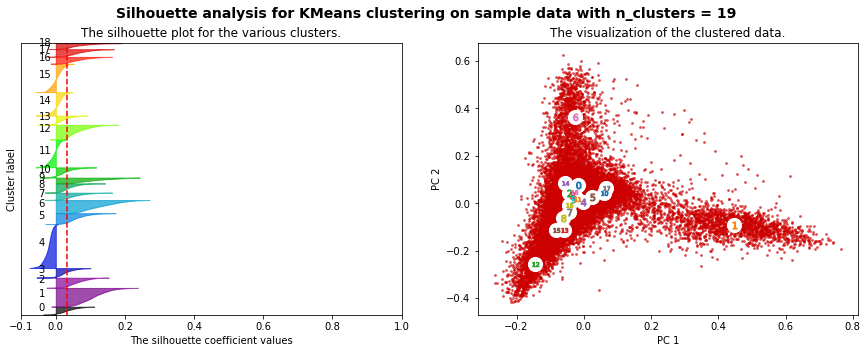

For n_clusters = 19, The average silhouette_score is : 0.032


In [123]:
# Silhouette
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(nowTFVects.toarray())
reduced_data = pca.transform(nowTFVects.toarray())
X = nowTFVects.toarray()
for n in range(10, 20): 
    plotSilhouette(n, X)

Generally, the average silhouette score increases with the number of clusters. The increasing trend becomes slow after n reaches 10. 

In [124]:
# top 10 words in 10 clusters
Kmeans(10)

Top terms per cluster:
Cluster 0:
 health
 says
 just
 life
 work
 years
 children
 day
 family
 community


Cluster 1:
 electric
 vehicles
 car
 vehicle
 cars
 company
 india
 technology
 driving
 market


Cluster 2:
 company
 technology
 business
 data
 companies
 market
 digital
 services
 industry
 global


Cluster 3:
 tax
 economic
 government
 income
 growth
 economy
 poverty
 countries
 inequality
 world


Cluster 4:
 women
 gender
 men
 female
 equality
 girls
 violence
 woman
 work
 rights


Cluster 5:
 nigeria
 nan
 news
 gathering
 substantial
 36
 knows
 states
 state
 efficient


Cluster 6:
 game
 season
 players
 team
 games
 league
 play
 just
 good
 win


Cluster 7:
 city
 transport
 cities
 road
 traffic
 project
 public
 bus
 urban
 transportation


Cluster 8:
 party
 trump
 president
 political
 government
 election
 anc
 south
 democratic
 state


Cluster 9:
 students
 education
 school
 schools
 university
 student
 universities
 children
 college
 teachers




<ipython-input-118-42c43bb65dc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nowDF_2019['kmeans_predictions'] = km.labels_


Health, transportation, tax, gender, education are some areas that are always talked about in inequality news. 

Dataset 2: 700 fiction written by EAP, HPL, and MWS from [this Kaggle project](https://www.kaggle.com/c/spooky-author-identification/data?select=sample_submission.zip). 

In [5]:
fiction_df = pandas.read_csv('fiction.csv')
fiction_df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
694,id13361,Down this new opening the eye cannot penetrate...,EAP
695,id06893,Ye gods and what do I behold is that the depar...,EAP
696,id27508,From those blurred and fragmentary memories we...,HPL
697,id17969,Then again she sadly lamented her hard fate; t...,MWS


In [7]:
#First it needs to be initialized
ficCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
ficVects = ficCountVectorizer.fit_transform(fiction_df['text'])
print(ficVects.shape)

#initialize
ficTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(ficVects)
#train
ficTF = ficTFTransformer.transform(ficVects)
print(ficTF.shape)

(699, 4692)
(699, 4692)


In [8]:
list(zip(ficCountVectorizer.vocabulary_.keys(), ficTF.data))[:20]

[('this', 0.15265264863138697),
 ('process', 0.22725486515969687),
 ('however', 0.19689126696932852),
 ('afforded', 0.21381875891683527),
 ('me', 0.05928397436297208),
 ('no', 0.09967053991739985),
 ('means', 0.17662033434650284),
 ('of', 0.12408070381566592),
 ('ascertaining', 0.1813165144917575),
 ('the', 0.15095291630138913),
 ('dimensions', 0.19084958358286558),
 ('my', 0.22725486515969687),
 ('dungeon', 0.19084958358286558),
 ('as', 0.2042856898257272),
 ('might', 0.14779457375533825),
 ('make', 0.1575622840792782),
 ('its', 0.11240898848984843),
 ('circuit', 0.08246221988791434),
 ('and', 0.1435584934449905),
 ('return', 0.1813165144917575)]

In [9]:
#initialize
ficTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, 
                                                                  min_df=3, stop_words='english', norm='l2')
#train
ficTFVects = ficTFVectorizer.fit_transform(fiction_df['text'])
print(ficTFVects.shape)

(699, 668)


In [10]:
list(zip(ficTFVectorizer.vocabulary_.keys(), ficTFVects.data))[:20]

[('means', 0.3470348433996941),
 ('make', 0.36006803891669575),
 ('return', 0.3195832358691029),
 ('point', 0.36006803891669575),
 ('set', 0.3195832358691029),
 ('aware', 0.33638594728477234),
 ('fact', 0.33638594728477234),
 ('perfectly', 0.2959011442371795),
 ('wall', 0.3195832358691029),
 ('occurred', 0.7071067811865475),
 ('mere', 0.7071067811865475),
 ('left', 0.31379335165526706),
 ('hand', 0.29054030808688613),
 ('gold', 0.29553032892869163),
 ('box', 0.3214512517516085),
 ('hill', 0.3214512517516085),
 ('manner', 0.3407476188649445),
 ('steps', 0.3535446921937015),
 ('took', 0.3214512517516085),
 ('air', 0.3070386050569397)]

In [12]:
# K means
def Kmeans(numClusters):
    km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
    km.fit(ficTFVects)
    fiction_df['kmeans_predictions'] = km.labels_

    terms = ficTFVectorizer.get_feature_names()
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(numClusters):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')

In [13]:
Kmeans(2)

Top terms per cluster:
Cluster 0:
 said
 man
 old
 heard
 time
 night
 great
 life
 like
 little


Cluster 1:
 did
 cold
 raymond
 mind
 gentle
 reward
 degree
 mr
 hours
 forgotten




In [14]:
Kmeans(3)

Top terms per cluster:
Cluster 0:
 did
 man
 old
 time
 great
 like
 night
 little
 appeared
 saw


Cluster 1:
 said
 say
 thoughts
 youth
 sir
 legrand
 skull
 broken
 evident
 better


Cluster 2:
 heard
 life
 passed
 heart
 felt
 years
 necessary
 best
 gentle
 secure




In [15]:
Kmeans(4)

Top terms per cluster:
Cluster 0:
 said
 man
 old
 night
 life
 like
 time
 little
 great
 saw


Cluster 1:
 did
 cold
 raymond
 mind
 gentle
 reward
 degree
 mr
 hours
 forgotten


Cluster 2:
 black
 head
 gentleman
 form
 foot
 cloak
 great
 land
 wide
 let


Cluster 3:
 heard
 sound
 broken
 things
 new
 ship
 come
 wildest
 gods
 fears




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


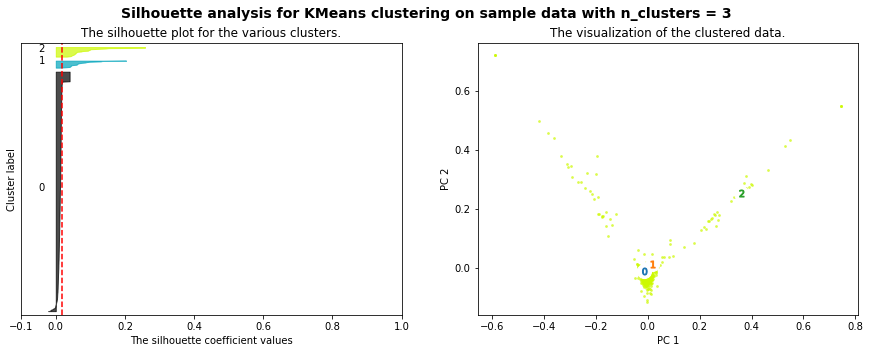

For n_clusters = 3, The average silhouette_score is : 0.017


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


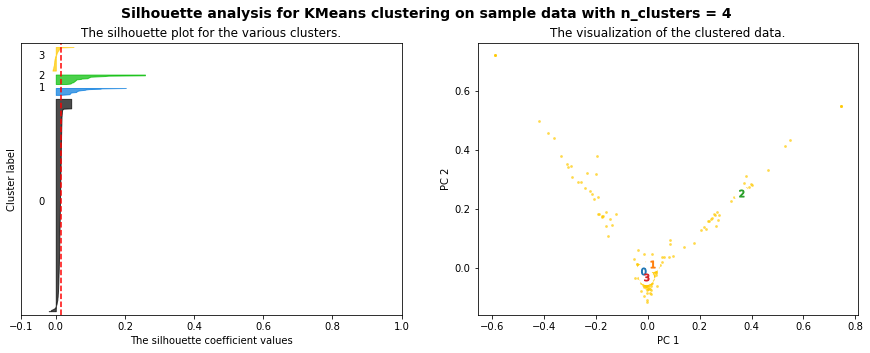

For n_clusters = 4, The average silhouette_score is : 0.016


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


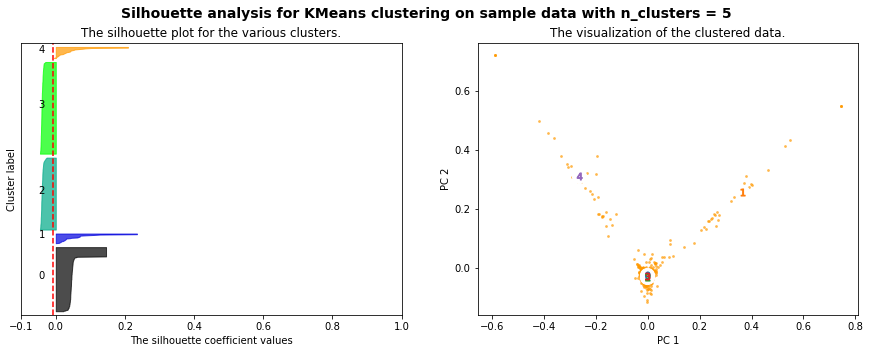

For n_clusters = 5, The average silhouette_score is : -0.007


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


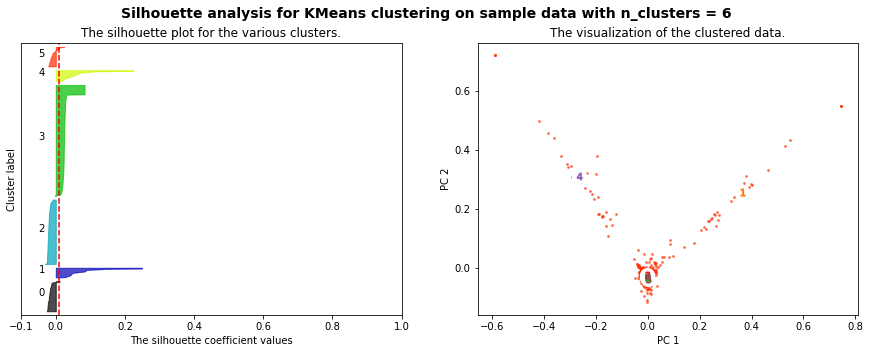

For n_clusters = 6, The average silhouette_score is : 0.010


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


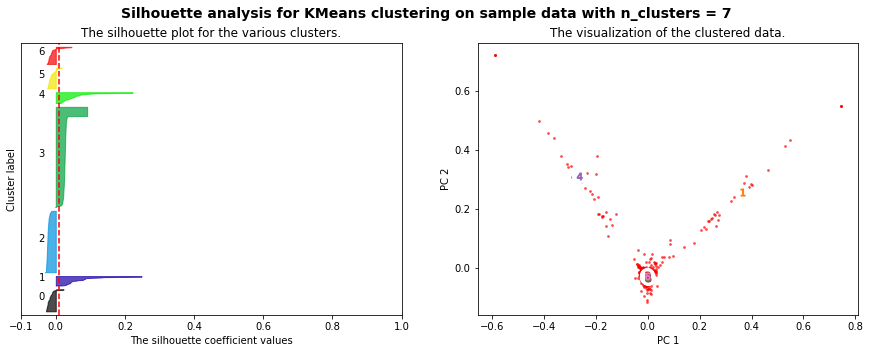

For n_clusters = 7, The average silhouette_score is : 0.009


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


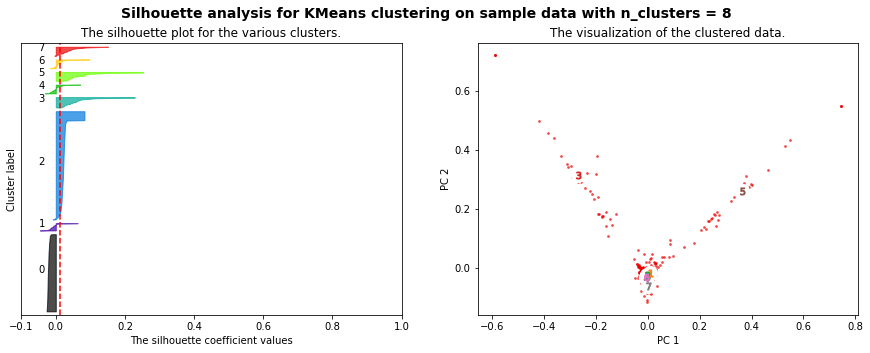

For n_clusters = 8, The average silhouette_score is : 0.012


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


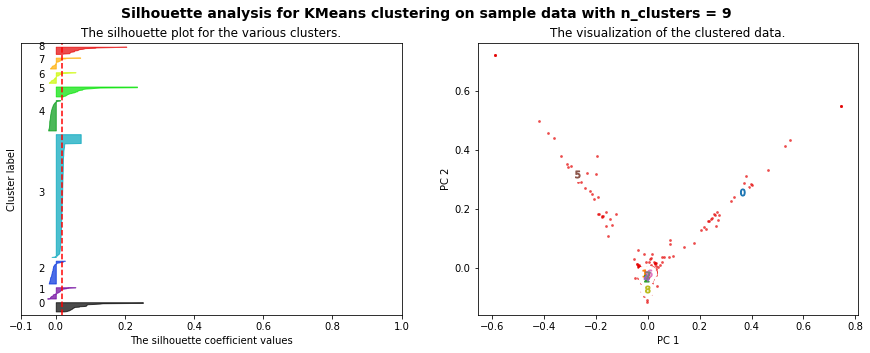

For n_clusters = 9, The average silhouette_score is : 0.017


In [20]:
# Silhouette
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(ficTFVects.toarray())
reduced_data = pca.transform(ficTFVects.toarray())
X = ficTFVects.toarray()
for n in range(3, 10): 
    plotSilhouette(n, X)

The dataset contains text from works of fiction written by 3 authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. We can see that when number of clusters is 3 and 9, the silhouette score is the largest. The "unsuccessful" clustering probably is caused by the small size of dataset - I only include 700 texts here. 

In [21]:
# True class
colordict = {
'EAP': 'red',
'HPL': 'green',
'MWS': 'blue',}

colors = [colordict[c] for c in fiction_df['author']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('EAP', 'red'), ('HPL', 'green'), ('MWS', 'blue')])


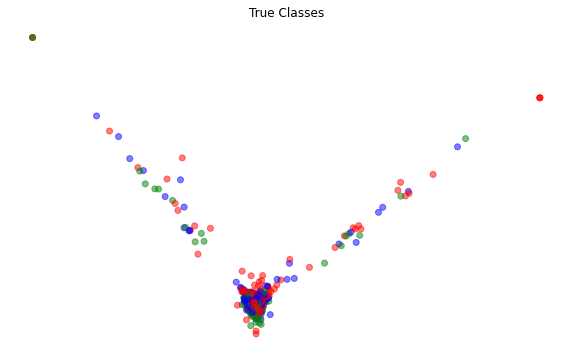

In [22]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

From the above graph, we could see that the true class distribution is not so good, the three authors' texts could barely be distinguished.

In [23]:
ficCategories = ['EAP', 'HPL', 'MWS']

Top terms per cluster:
Cluster 0:
 said
 man
 old
 heard
 night
 time
 great
 life
 like
 appeared


Cluster 1:
 did
 cold
 raymond
 mind
 gentle
 reward
 degree
 mr
 hours
 forgotten


Cluster 2:
 say
 gave
 come
 doubt
 soul
 dare
 tell
 course
 said
 world




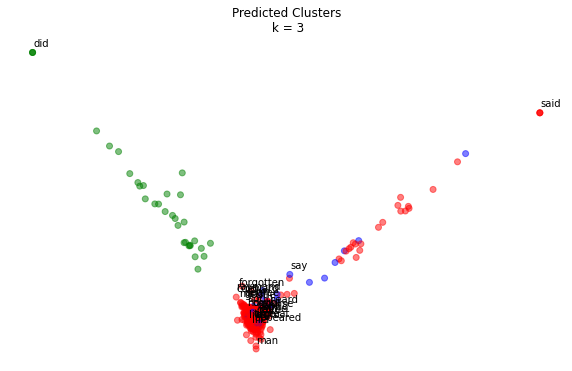

In [27]:
# K = 3
numClusters=3
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(ficTFVects)
fiction_df['kmeans_predictions'] = km.labels_

terms = ficTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
    
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

colors_p = [colordict[ficCategories[l]] for l in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

In [28]:
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(fiction_df['author'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(fiction_df['author'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(fiction_df['author'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(fiction_df['author'], km.labels_)))

For our clusters:
Homogeneity: 0.003
Completeness: 0.008
V-measure: 0.005
Adjusted Rand Score: -0.004


# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [92]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [93]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [94]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


C:\Users\xiche\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [95]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [96]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [97]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

C:\Users\xiche\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 143.        ,   0.        ,   2.        ],
       [145.        , 200.        ,   0.        ,   3.        ],
       [148.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 119.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 112.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

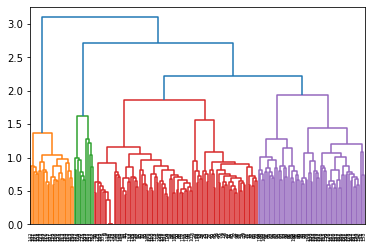

In [98]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

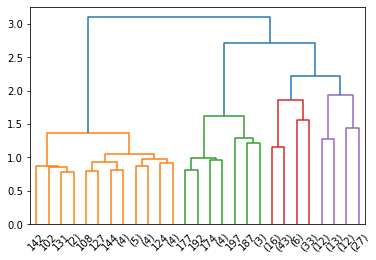

In [99]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [100]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2,
       4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2,
       4, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [101]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [102]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,0,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,1,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data\20news_home\20news-b...,1,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data\20news_home\20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [103]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

C:\Users\xiche\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\xiche\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

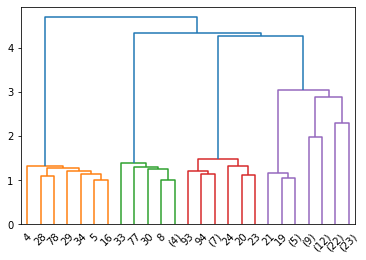

In [104]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [105]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

Dataset 1: News in NOW

In [123]:
nowCoocMat = nowTFVects * nowTFVects.T
nowCoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(nowCoocMat[:100, :100].toarray())

C:\Users\xiche\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\xiche\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


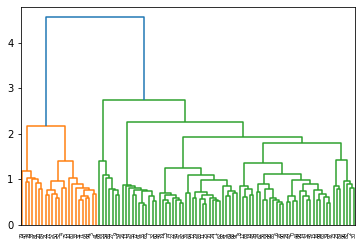

In [124]:
# approach 1
d = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

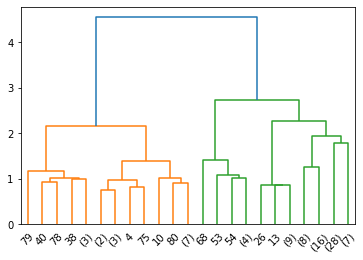

In [125]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [126]:
# approach 2
linkage_matrix_full = scipy.cluster.hierarchy.ward(nowCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')

In [128]:
nowDF_2019['wald_predictions'] = hierarchicalClusters_full
nowDF_2019[:10]

<ipython-input-128-970e7f1c88d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nowDF_2019['wald_predictions'] = hierarchicalClusters_full


,textID,texts,year,kmeans_predictions,wald_predictions
0,50321297,"With summer well and truly upon us , there is...",2019,0,2
1,50323336,The Roman emperor Augustus is held up by some...,2019,0,4
2,50326050,1 in 6 women experience physical and/or sexua...,2019,0,3
3,50326526,Toyota HiLux is the best selling vehicle in t...,2019,1,2
4,50326747,"Hop Lin Jong , seen here in 1948 , was born i...",2019,0,4
5,50329033,November 2020 : President Trump has lost the ...,2019,0,4
6,50330061,Heart Cafe in Bondi deserves praise for its m...,2019,0,4
7,50330865,Looking for the latest in entertainment acros...,2019,0,3
8,50331368,6 January 2019 -- 2:06pm Are we doing enoug...,2019,1,2
9,50331381,"Lisa Wilkinson has congratulated the new "" fa...",2019,3,3


Dataset 2

In [29]:
groupsCoocMat = ficTFVects * ficTFVects.T
groupsCoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(groupsCoocMat[:100, :100].toarray())

C:\Users\xiche\anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
C:\Users\xiche\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


approach 1

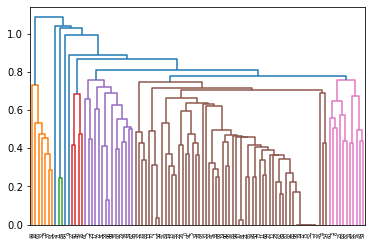

In [30]:
d=scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

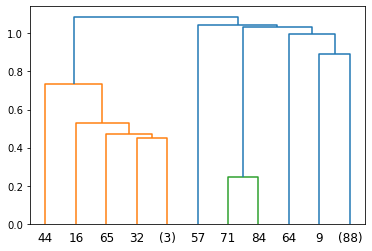

In [31]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

approach 2

In [32]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(groupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 
                                                             4, 'maxclust')

In [33]:
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(fiction_df['author'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(fiction_df['author'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(fiction_df['author'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(fiction_df['author'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.004
Completeness: 0.010
V-measure: 0.006
Adjusted Rand Score: 0.000


In [34]:
fiction_df['cluster'] = hierarchicalClusters_full
fiction_df[fiction_df.cluster==1].head(10)

,id,text,author,kmeans_predictions,cluster
89,id10676,All that he said threw greatly into the shade ...,MWS,0,1
92,id19878,"""Keep up the largest branch the one on this si...",EAP,0,1
101,id21482,"""But, my dear fellow, you are joking then,"" sa...",EAP,2,1
107,id06564,"As I have said, it happened when we were in th...",HPL,0,1
149,id05449,"In order to reach it, he said, he would soar t...",HPL,0,1
164,id11826,"He was full of thought, and remained silent du...",MWS,0,1
175,id12080,"""Not so,"" said I, ""though I confess that my th...",MWS,0,1
197,id25698,"""Ha ha ha"" said that gentleman ""he he he hi hi...",EAP,0,1
225,id17577,"A closer scrutiny, however, satisfied me that ...",EAP,2,1
276,id23496,"""No"" said the Baron, turning abruptly toward t...",EAP,2,1


In [35]:
fiction_df[fiction_df.cluster==2].head(10)

,id,text,author,kmeans_predictions,cluster
34,id03205,Sheehan especially did they ply with inquiries...,HPL,1,2
74,id06412,Nor did Raymond make an end without drawing in...,MWS,1,2
104,id04159,I shivered as I wondered why I did not reach t...,HPL,1,2
129,id10113,I had now spent many hours in tears and mournf...,MWS,1,2
131,id24267,"He did not himself understand these words, or ...",HPL,1,2
141,id05582,He did not try to navigate after the first bol...,HPL,1,2
170,id15774,"Raymond did not wonder, that, thus situated, t...",MWS,1,2
180,id05110,At Lawrence he had been prominent in the mock ...,HPL,1,2
191,id12020,"Scarcely had we recovered our senses, before t...",EAP,1,2
285,id15959,"""O yes; and for this reason I did not despair.",EAP,1,2


In [36]:
fiction_df[fiction_df.cluster==3].head(10)

,id,text,author,kmeans_predictions,cluster
23,id19925,With how deep a spirit of wonder and perplexit...,EAP,2,3
44,id21136,"It is not to be supposed, however, that the gr...",EAP,0,3
48,id02236,"Dr. Johnson, as I beheld him, was a full, purs...",HPL,0,3
80,id08521,"My lieutenant, for instance, is a man of wonde...",MWS,0,3
124,id13315,Then the lean Nith remarked that no one had se...,HPL,0,3
159,id09713,I had not entered the army on my own initiativ...,HPL,0,3
213,id27169,Else there is no immortality for man.,EAP,0,3
257,id04970,"This man, whose name was Beaufort, was of a pr...",MWS,0,3
320,id10482,"Whenever it fell upon me, my blood ran cold; a...",EAP,0,3
339,id06471,"To this man Iranon spoke, as to so many others...",HPL,0,3


Again, by interrogating the cluster content, the text structure breaks the fiction topic cluster pattern. The reason could be the sizes of texts are relatively small and hence a large variance in word occurrence.

But surprisingly, these metrics perform better than Kmeans. This could be because of a potential hierarchical structure in the corpus (i.e., text--topic--author)

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [129]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [130]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [131]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [132]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [133]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [134]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [135]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [136]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(3, 0.97351104)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [137]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [138]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(5, 0.97151434)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.971514,0.000000,0.0,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(0, 0.6804051), (1, 0.31518134)]",0.680405,0.315181,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(4, 0.99763894)]",0.000000,0.000000,0.000000,0.000000,0.997639,0.000000,0.000000,0.0,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(3, 0.6969383), (4, 0.30123034)]",0.000000,0.000000,0.000000,0.696938,0.301230,0.000000,0.000000,0.0,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(0, 0.29654583), (9, 0.6975345)]",0.296546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.697535
501,09Nov2005Kennedy11.txt,"[(0, 0.7544014), (6, 0.20622632)]",0.754401,0.000000,0.000000,0.000000,0.000000,0.000000,0.206226,0.0,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(5, 0.9722232)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.972223,0.000000,0.0,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.055891506), (2, 0.19398719), (3, 0.0111...",0.055892,0.000000,0.193987,0.011104,0.536905,0.000000,0.079755,0.0,0.121058,0.000000
801,15Dec2005Kennedy5.txt,"[(2, 0.023610068), (4, 0.49656713), (5, 0.3885...",0.000000,0.000000,0.023610,0.000000,0.496567,0.388546,0.000000,0.0,0.089915,0.000000
901,16May2007Kennedy5.txt,"[(4, 0.954214)]",0.000000,0.000000,0.000000,0.000000,0.954214,0.000000,0.000000,0.0,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [140]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.000000,0.973510,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.971514,0.000000,0.000000,0.0,0.000000
2,0.000000,0.019339,0.974446,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.993968
4,0.081590,0.000000,0.553827,0.362772,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.452784,0.000000,0.466226,0.000000,0.074288,0.000000,0.0,0.000000
6,0.438067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552328,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.711470,0.000000,0.000000,0.000000,0.0,0.259657
8,0.000000,0.365297,0.608767,0.000000,0.000000,0.022093,0.000000,0.000000,0.0,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.967374,0.000000,0.000000,0.0,0.000000


First we can visualize as a stacked bar chart:

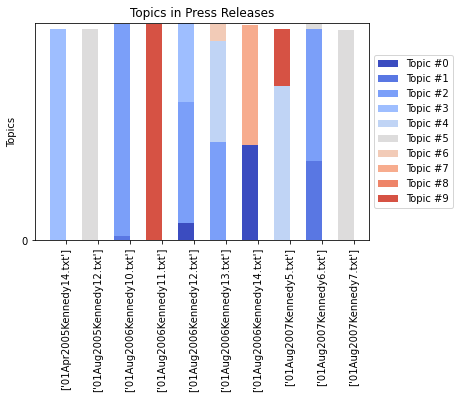

In [141]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

<ipython-input-142-6aea57f70a71>:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Blues')


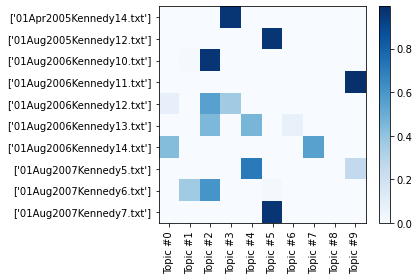

In [142]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [143]:
senlda.show_topic(1)

[('loan', 0.0063679237),
 ('fund', 0.0062059066),
 ('coverage', 0.005529777),
 ('mental', 0.0046286127),
 ('troop', 0.0045254114),
 ('lender', 0.0041005923),
 ('teacher', 0.0036000293),
 ('fail', 0.003508555),
 ('worker', 0.0034210272),
 ('insurance', 0.003218053)]

And if we want to make a dataFrame:

In [144]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,loan,loan,worker,fund,loan,wage,worker,fund,worker
1,worker,fund,worker,immigration,worker,fund,minimum,fund,worker,teacher
2,troop,coverage,head,immigrant,pension,worker,fund,immigration,troop,wage
3,intelligence,mental,wage,fund,stem,medicare,worker,judge,company,minimum
4,company,troop,minimum,head,cell,lender,head,woman,unite,loan
5,concern,lender,fund,unite,company,asbestos,unite,hear,follow,tobacco
6,unite,teacher,lender,employer,immigration,company,woman,bankruptcy,asbestos,fda
7,medicare,fail,asbestos,agency,rule,woman,follow,pension,victim,unite
8,fda,worker,bankruptcy,woman,unite,troop,agency,border,iraqi,immigrant
9,fail,insurance,company,border,retirement,judge,rate,troop,sick,document


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

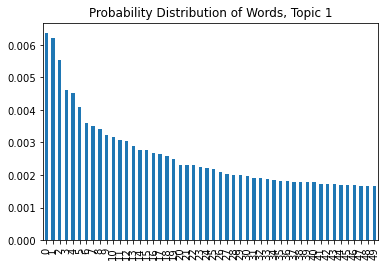

In [145]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [146]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

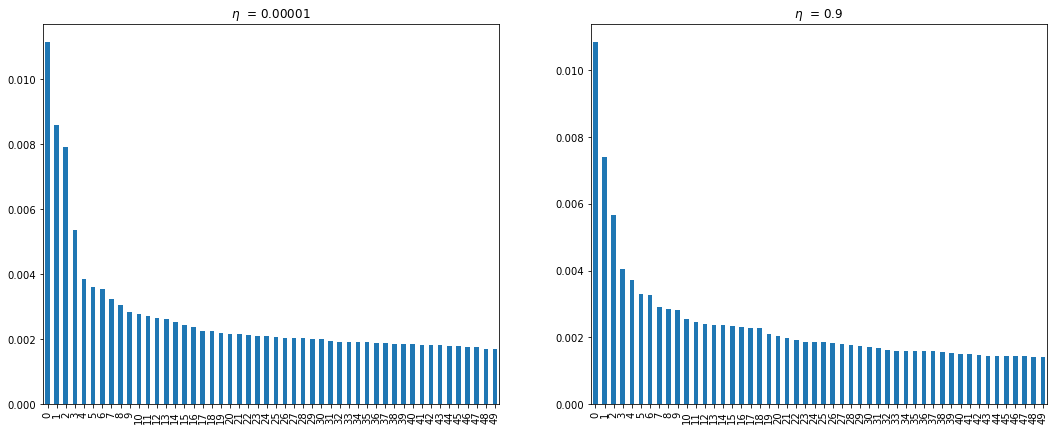

In [147]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [294]:
now_sample = nowDF_2019[:1500][:]
now_sample

,textID,texts,year,kmeans_predictions,wald_predictions,tokenized_text
0,50321297,"With summer well and truly upon us , there is...",2019,0,2,"[With, summer, well, and, truly, upon, us, the..."
1,50323336,The Roman emperor Augustus is held up by some...,2019,0,4,"[The, Roman, emperor, Augustus, is, held, up, ..."
2,50326050,1 in 6 women experience physical and/or sexua...,2019,0,3,"[1, in, 6, women, experience, physical, and/or..."
3,50326526,Toyota HiLux is the best selling vehicle in t...,2019,1,2,"[Toyota, HiLux, is, the, best, selling, vehicl..."
4,50326747,"Hop Lin Jong , seen here in 1948 , was born i...",2019,0,4,"[Hop, Lin, Jong, seen, here, in, 1948, was, bo..."
...,...,...,...,...,...,...
1502,40473138,The Peoples Democratic Party ( PDP ) has susp...,2019,2,1,"[The, Peoples, Democratic, Party, PDP, has, su..."
1503,40473157,The BMW Group is committed to the ongoing exp...,2019,1,2,"[The, BMW, Group, is, committed, to, the, ongo..."
1504,40473164,LeddarTech 's products will now be compatible...,2019,1,2,"[LeddarTech, 's, products, will, now, be, comp..."
1505,40473365,Aubert &amp; Duval is a world leader in indus...,2019,1,2,"[Aubert, amp, Duval, is, a, world, leader, in,..."


In [295]:
now_sample['tokenized_text'] = now_sample['texts'].apply(lambda x: lucem_illud.word_tokenize(x))
now_sample['normalized_tokens'] = now_sample['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [296]:
now_sample

,textID,texts,year,kmeans_predictions,wald_predictions,tokenized_text,normalized_tokens
0,50321297,"With summer well and truly upon us , there is...",2019,0,2,"[With, summer, well, and, truly, upon, us, the...","[summer, truly, well, time, check, beauty, won..."
1,50323336,The Roman emperor Augustus is held up by some...,2019,0,4,"[The, Roman, emperor, Augustus, is, held, up, ...","[roman, emperor, augustus, hold, statesman, br..."
2,50326050,1 in 6 women experience physical and/or sexua...,2019,0,3,"[1, in, 6, women, experience, physical, and/or...","[woman, experience, physical, and/or, sexual, ..."
3,50326526,Toyota HiLux is the best selling vehicle in t...,2019,1,2,"[Toyota, HiLux, is, the, best, selling, vehicl...","[toyota, hilux, well, sell, vehicle, country, ..."
4,50326747,"Hop Lin Jong , seen here in 1948 , was born i...",2019,0,4,"[Hop, Lin, Jong, seen, here, in, 1948, was, bo...","[hop, lin, jong, see, bear, guangzhou, arrive,..."
...,...,...,...,...,...,...,...
1502,40473138,The Peoples Democratic Party ( PDP ) has susp...,2019,2,1,"[The, Peoples, Democratic, Party, PDP, has, su...","[people, democratic, party, pdp, suspend, depu..."
1503,40473157,The BMW Group is committed to the ongoing exp...,2019,1,2,"[The, BMW, Group, is, committed, to, the, ongo...","[bmw, group, commit, ongoing, expansion, intel..."
1504,40473164,LeddarTech 's products will now be compatible...,2019,1,2,"[LeddarTech, 's, products, will, now, be, comp...","[leddartech, product, compatible, apollo, late..."
1505,40473365,Aubert &amp; Duval is a world leader in indus...,2019,1,2,"[Aubert, amp, Duval, is, a, world, leader, in,...","[aubert, amp, duval, world, leader, industrial..."


In [297]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

now_sample['reduced_tokens'] = now_sample['normalized_tokens'].apply(lambda x: dropMissing(x, nowTFVectorizer.vocabulary_.keys()))

In [298]:
dictionary = gensim.corpora.Dictionary(now_sample['reduced_tokens'])

In [299]:
corpus = [dictionary.doc2bow(text) for text in now_sample['reduced_tokens']]

In [300]:
gensim.corpora.MmCorpus.serialize('now.mm', corpus)
nowmm = gensim.corpora.MmCorpus('now.mm')

In [301]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [302]:
now1Bow = dictionary.doc2bow(now_sample['reduced_tokens'][0])
now1lda = nowlda[now1Bow]

In [303]:
print("The topics of the text: {}".format(now_sample['textID'][2]))
print("are: {}".format(now1lda))

The topics of the text: 50326050
are: [(1, 0.49959934), (5, 0.29136986), (8, 0.20191202)]


In [304]:
ldaDF = pandas.DataFrame({
        'ID' : now_sample['textID'],
        'topics' : [nowlda[dictionary.doc2bow(l)] for l in now_sample['reduced_tokens']]
    })

In [305]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(nowlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(nowlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF.head(5)

,ID,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,50321297,"[(1, 0.49478287), (5, 0.31236696), (8, 0.18573...",0.000000,0.494783,0.000000,0.0,0.000000,0.312367,0.000000,0.000000,0.185731,0.0
1,50323336,"[(1, 0.05292586), (2, 0.37186286), (6, 0.07943...",0.000000,0.052926,0.371863,0.0,0.000000,0.000000,0.079437,0.443445,0.048065,0.0
2,50326050,"[(5, 0.8823931), (8, 0.11195722)]",0.000000,0.000000,0.000000,0.0,0.000000,0.882393,0.000000,0.000000,0.111957,0.0
3,50326526,"[(4, 0.0138971), (7, 0.9734466)]",0.000000,0.000000,0.000000,0.0,0.013897,0.000000,0.000000,0.973447,0.000000,0.0
4,50326747,"[(0, 0.06642778), (2, 0.5709862), (5, 0.151133...",0.066428,0.000000,0.570986,0.0,0.000000,0.151133,0.027490,0.000000,0.176180,0.0


In [306]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['ID']]
#ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVis = ldaDFV.values
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.494783,0.000000,0.000000,0.000000,0.312367,0.000000,0.000000,0.185731,0.00000
1,0.000000,0.052926,0.371863,0.000000,0.000000,0.000000,0.079437,0.443445,0.048065,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.882393,0.000000,0.000000,0.111957,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.013897,0.000000,0.000000,0.973447,0.000000,0.00000
4,0.066428,0.000000,0.570986,0.000000,0.000000,0.151133,0.027490,0.000000,0.176180,0.00000
5,0.000000,0.043790,0.061572,0.000000,0.000000,0.000000,0.000000,0.000000,0.838737,0.05342
6,0.064134,0.000000,0.000000,0.505342,0.152312,0.182791,0.000000,0.000000,0.090532,0.00000
7,0.139609,0.037849,0.000000,0.000000,0.016163,0.243049,0.000000,0.000000,0.561194,0.00000
8,0.071786,0.000000,0.000000,0.000000,0.000000,0.000000,0.669770,0.253971,0.000000,0.00000
9,0.000000,0.557833,0.000000,0.000000,0.000000,0.407719,0.000000,0.000000,0.025728,0.00000


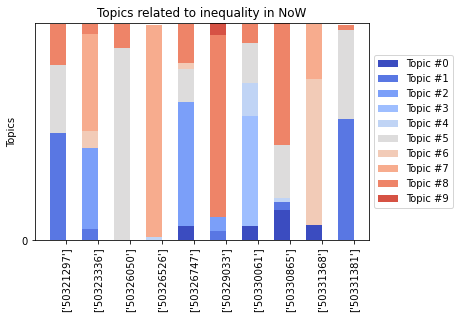

In [307]:
# visulization
N = 10
ind = np.arange(N)
K = nowlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    
plt.ylim((0, 1))  
plt.ylabel('Topics')

plt.title('Topics related to inequality in NoW')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

<ipython-input-308-3652064bcbe2>:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Blues')


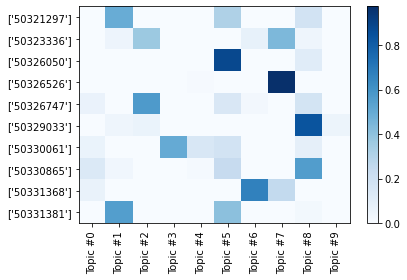

In [308]:
# Heatmap
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()
# rotate the ticks on the x-axis
plt.xticks(rotation=90)
# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [309]:
nowlda.show_topic(7) # topic top words

[('say', 0.02136285),
 ('state', 0.0116247805),
 ('vehicle', 0.009582343),
 ('country', 0.00945978),
 ('work', 0.007818496),
 ('government', 0.0070317797),
 ('president', 0.006972006),
 ('need', 0.006723745),
 ('world', 0.0066288696),
 ('include', 0.00656871)]

In [310]:
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,say,say,say,say,government,say,say,say,say,say
1,woman,woman,government,need,say,work,government,state,state,country
2,work,come,work,work,work,woman,country,vehicle,world,world
3,government,government,world,country,india,government,city,country,government,government
4,come,report,day,india,world,need,social,work,country,cent
5,world,country,come,business,need,school,world,government,work,work
6,city,world,continue,woman,change,country,increase,president,cent,state
7,report,include,university,government,help,service,work,need,high,public
8,india,long,economic,company,company,come,support,world,health,market
9,need,issue,high,help,group,child,high,include,right,come


<Figure size 432x288 with 0 Axes>

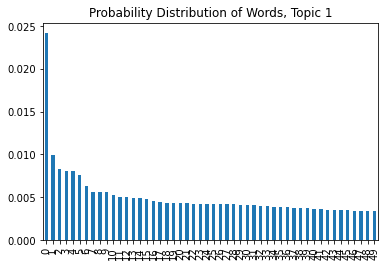

In [311]:
topic1_df = pandas.DataFrame(nowlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

<Figure size 432x288 with 0 Axes>

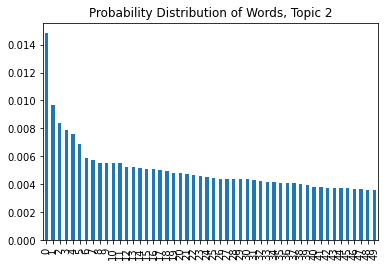

In [312]:
topic_df = pandas.DataFrame(nowlda.show_topic(2, topn=50))
plt.figure()
topic_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 2')
plt.show()

In [313]:
# change eta
nowlda1 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=10, eta = 0.00001)
nowlda2 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, num_topics=10, eta = 0.9)

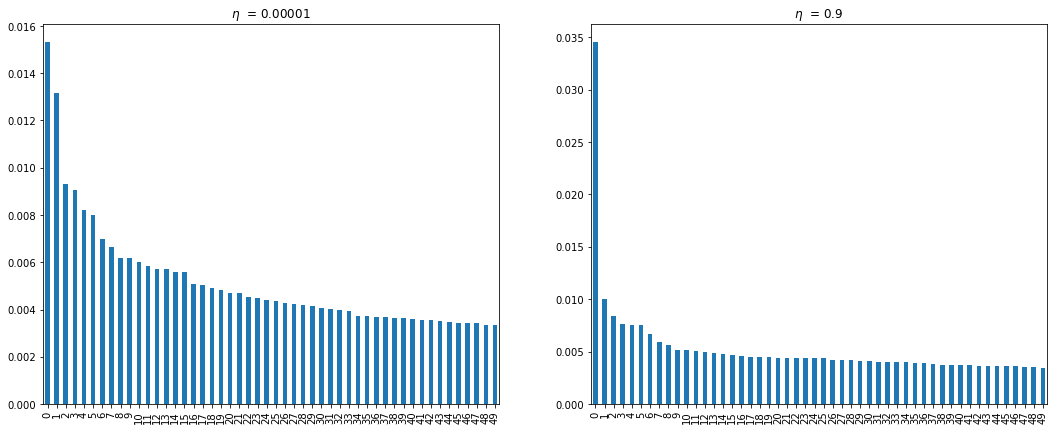

In [314]:
topic11_df = pandas.DataFrame(nowlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(nowlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

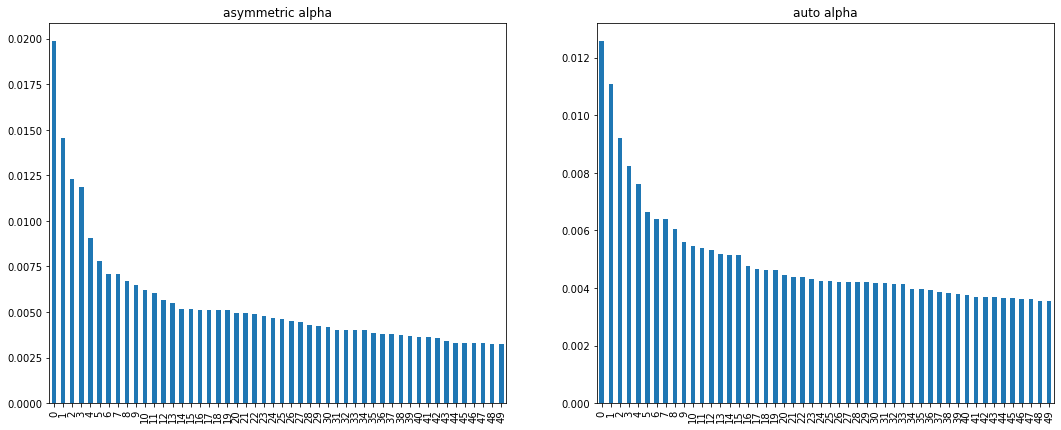

In [315]:
### change alpha
nowlda1 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=10, alpha = "asymmetric")
nowlda2 = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=10, alpha = "auto")

topic11_df = pandas.DataFrame(nowlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(nowlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'asymmetric alpha')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'auto alpha')
plt.show()

In [318]:
# change topic number
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=5, eta = 0.0001)
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,say,say,say,say,say
1,government,work,school,government,work
2,world,government,woman,country,need
3,woman,country,work,work,service
4,country,world,country,state,come
5,right,need,state,need,government
6,work,woman,come,world,issue
7,business,child,need,woman,city
8,state,state,student,president,vehicle
9,india,come,company,include,world


In [319]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.9)
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.0001)
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)
print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

      Topic_0     Topic_1  Topic_2     Topic_3     Topic_4     Topic_5
0         say         say     work         say         say         say
1  government  government      say        work  government     country
2        need       state    woman  government     country       world
3     country        work    world        cent        work       india
4       state       woman     come        need     service        high
5        work     vehicle  country        come       world        need
6       woman       world    state       woman      market  government
7       child       right     need         job     company    economic
8        come         day     high       state       india        city
9        help   community  include      public         day        work


      Topic_0     Topic_1     Topic_2     Topic_3     Topic_4     Topic_5
0         say         say         say         say         say         say
1  government  government  government        work        work       w

In [320]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, alpha = "asymmetric")
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, alpha = "auto")
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)
print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

      Topic_0     Topic_1     Topic_2     Topic_3     Topic_4     Topic_5
0         say       woman         say         say         say         say
1        work         say  government       world        work       woman
2  government     country       india        work     service  government
3       state  government     country  government        need        work
4     student        need       world     country     include       world
5        high       right      public        need  government     country
6      market         car        need    business     vehicle        come
7        know       india       state        come     country       state
8       child       world        come         way        help       issue
9        need        come     include       woman      social        need


     Topic_0     Topic_1     Topic_2     Topic_3     Topic_4     Topic_5
0        say         say         say         say         say         say
1      world  government        work  

In [321]:
nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.0001, alpha = "asymmetric")
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF1 = pandas.DataFrame(topicsDict)

nowlda = gensim.models.ldamodel.LdaModel(corpus=nowmm, id2word=dictionary, 
                                          num_topics=6, eta = 0.09, alpha = "auto")
topicsDict = {}
for topicNum in range(nowlda.num_topics):
    topicWords = [w for w, p in nowlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF2 = pandas.DataFrame(topicsDict)
print(wordRanksDF1)
print("\n")
print(wordRanksDF2)

      Topic_0     Topic_1     Topic_2     Topic_3     Topic_4     Topic_5
0         say         say         say         say         say         say
1     country  government  government        work       woman       woman
2  government        work       india       woman  government       india
3       state       world        work       world        come     country
4        need       state     country     country        work         man
5        high     country       child     include      social  government
6     include        need       world        need      change        work
7     provide     service       woman  government        need         day
8        cent        come    business        come       world        need
9      report         day        need        help        plan   community


      Topic_0     Topic_1     Topic_2     Topic_3     Topic_4     Topic_5
0         say         say       woman         say         say         say
1        work      school         sa

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [241]:
corpora_address = "/Users/xiche/Downloads/SOAP/SOAP"

file = "SOAP"

In [242]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [243]:
import zipfile
import pandas as pd

In [244]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [245]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [246]:
soap_dict = {}

In [247]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [248]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [249]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [250]:
i = 0

In [251]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [252]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [253]:
dool = soap_df['Tokenized Texts'][9]

In [254]:
' '.join(dool[0:1500])

"@!Sharon Yeah I could n't sleep @!Victoria Nightmares @!Sharon Vicki thank you for spending the night @!Victoria Of course I would n't leave you and the kids alone You want to talk about it @!Sharon I do n't think I can @!Victoria It might help to get it out @!Sharon You know the worst part is n't when Matt Clark attacked me It was when he made me stare into his eyes He had this old picture of the way he used to look And I kept going from the picture to his face And then it was like like a horror movie or something I could n't breathe I felt like I was back in that car again @!Victoria Sharon there is nothing I can do or say to take the pain away I want you to know they will find him and you will never ever have to worry about Matt Clark ever again @!Nikki Hi You all right @!Victoria Any word on Matt Clark @!Nikki No they have him The police have helicopters They have search dogs @!Victor Apparently he left by car @!Sharon What car @!Victor Another set of tire marks were found near th

In [255]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [256]:
import networkx as nx

In [257]:
actor_network = nx.Graph()

In [258]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [259]:
i = 0

In [260]:
all_texts = []

In [262]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

KeyboardInterrupt: 

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

Network analysis

In [267]:
import networkx as nx

In [268]:
nowDF = now_sample[:100]

In [269]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [270]:
g = wordCooccurrence(nowDF['normalized_tokens'].sum())

In [271]:
print('Total number of vertices: ',len(g.nodes))
print('Total number of edges: ', len(g.edges))

Total number of vertices:  52
Total number of edges:  821


In [272]:
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

bVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence = bVectorizer.fit_transform(nowDF['texts'])
bVects_incidence

<100x9466 sparse matrix of type '<class 'numpy.int64'>'
	with 32839 stored elements in Compressed Sparse Row format>

In [273]:
g = nx.Graph()
g.add_nodes_from((bVectorizer.get_feature_names()[i] for i in range(bVects_incidence.shape[1])), bipartite = 'word')
g.add_nodes_from(range(bVects_incidence.shape[0]), bipartite = 'doc')
g.add_edges_from(((d, bVectorizer.get_feature_names()[w], {'weight' : bVects_incidence[d, w]}) 
                          for d, w in zip(*bVects_incidence.nonzero())))

In [274]:
def contractNetwork_all(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [328]:
g_word = contractNetwork_all(g, 'word')
g_word.remove_edges_from([(n1, n2) for n1, n2, d in g_word.edges(data = True) if d['weight'] <= 30])
g_word.remove_nodes_from(list(nx.isolates(g)))

In [329]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
giant = max(connected_component_subgraphs(g_word), key=len)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 578
Average degree:  15.6216


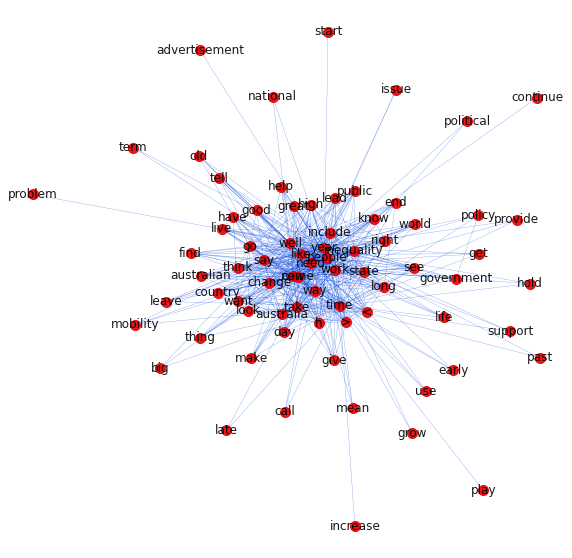

In [330]:
layout = nx.spring_layout(giant, weight='weight', iterations= 50)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:red",
        edge_color='xkcd:blue')

In [331]:
dool = nowDF['tokenized_text'][0]
dool

['With',
 'summer',
 'well',
 'and',
 'truly',
 'upon',
 'us',
 'there',
 'is',
 'no',
 'better',
 'time',
 'than',
 'now',
 'to',
 'check',
 'out',
 'all',
 'of',
 'the',
 'beauty',
 'and',
 'wonder',
 'the',
 'Grampians',
 'National',
 'Park',
 'has',
 'to',
 'offer',
 'In',
 'conjunction',
 'with',
 'Parks',
 'Victoria',
 'Grampians',
 'visitor',
 'and',
 'community',
 'ranger',
 'Connor',
 'Smith',
 'here',
 'is',
 'a',
 'list',
 'of',
 'nine',
 'of',
 'the',
 'top',
 'things',
 'to',
 'do',
 'in',
 'the',
 'Grampians',
 'this',
 'summer',
 'Related',
 'ParksVic',
 'to',
 'host',
 'Grampians',
 'safety',
 'session',
 'Mr',
 'Smith',
 'said',
 'while',
 'the',
 'Grampians',
 'is',
 'a',
 'great',
 'place',
 'to',
 'explore',
 'it',
 'is',
 'important',
 'people',
 'take',
 'care',
 'Please',
 'be',
 'responsible',
 'for',
 'your',
 'safety',
 'when',
 'out',
 'in',
 'the',
 'park',
 'Prepare',
 'make',
 'good',
 'choices',
 'and',
 'take',
 'responsibility',
 'for',
 'the',
 'cultur

In [332]:
all_texts = nowDF['normalized_tokens'].sum()
all_texts = [all_texts]
all_texts

[['summer',
  'truly',
  'well',
  'time',
  'check',
  'beauty',
  'wonder',
  'grampians',
  'national',
  'park',
  'offer',
  'conjunction',
  'park',
  'victoria',
  'grampians',
  'visitor',
  'community',
  'ranger',
  'connor',
  'smith',
  'list',
  'thing',
  'grampians',
  'summer',
  'relate',
  'parksvic',
  'host',
  'grampians',
  'safety',
  'session',
  'mr',
  'smith',
  'say',
  'grampians',
  'great',
  'place',
  'explore',
  'important',
  'people',
  'care',
  'responsible',
  'safety',
  'park',
  'prepare',
  'good',
  'choice',
  'responsibility',
  'cultural',
  'natural',
  'environment',
  'say',
  'ranger',
  'offer',
  'variety',
  'child',
  'activity',
  'grampians',
  'deep',
  'lead',
  'albion',
  'bushland',
  'reserve',
  'stawell',
  'mr',
  'smith',
  'say',
  'activity',
  'range',
  'grampians',
  'minibeast',
  'discovery',
  'track',
  'trace',
  'learn',
  'bush',
  'skill',
  'bike',
  'scavenger',
  'hunt',
  'information',
  'available',


In [333]:
dictionary = gensim.corpora.Dictionary(all_texts)
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, \
                id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [334]:
doollda.show_topics()

[(0,
  '0.009*"say" + 0.007*"year" + 0.005*"people" + 0.004*"time" + 0.004*"woman" + 0.004*"australia" + 0.003*"<" + 0.003*"work" + 0.003*"new" + 0.003*">"'),
 (1,
  '0.008*"say" + 0.006*"year" + 0.004*"australia" + 0.004*"time" + 0.004*"woman" + 0.004*"people" + 0.004*"new" + 0.004*">" + 0.003*"government" + 0.003*"like"'),
 (2,
  '0.008*"say" + 0.006*"year" + 0.005*"australia" + 0.005*"people" + 0.004*"woman" + 0.004*"time" + 0.004*"new" + 0.004*"school" + 0.003*"work" + 0.003*"country"'),
 (3,
  '0.007*"say" + 0.006*"people" + 0.006*"australia" + 0.005*"year" + 0.005*"woman" + 0.005*"new" + 0.005*"work" + 0.004*"government" + 0.004*"time" + 0.003*"well"'),
 (4,
  '0.006*"say" + 0.004*"people" + 0.004*"year" + 0.003*"time" + 0.003*"school" + 0.003*"australia" + 0.003*"work" + 0.003*"new" + 0.003*"like" + 0.003*"government"'),
 (5,
  '0.006*"say" + 0.004*"new" + 0.004*"year" + 0.004*"day" + 0.004*"australia" + 0.003*"time" + 0.003*"school" + 0.003*"woman" + 0.003*"people" + 0.003*"wor

We can see that "women", "school" appear a lot, so education and gender are important topic when considering inequality.